In [93]:
import os
import sys
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk

%matplotlib inline

## Download and load in all TESS LCs

In [94]:
# Function to wrap around juliet's get_TESS_data function to deal with multiple TESS sectors
def juliet_get_tess_data(lkf):
    for indf,thisf in enumerate(lkf):
        thist,thisf,thisferr = juliet.get_TESS_data(thisf)
        if indf == 0:
            t,f,ferr = thist,thisf,thisferr
        else:
            t,f,ferr = np.concatenate((t,thist)), np.concatenate((f,thisf)), \
                np.concatenate((ferr,thisferr))
    
    return t,f,ferr

In [95]:
# Basic constants
tesst0 = 2457000.0  # BJD offset for TESS timestamps

p1 = 3.37923577236328  # period in days
perr1 = .0001425314  # error on period in days
tc1 = 2459420.207144  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0018298243  # transit midpoint in days

In [96]:
# Print out needed t0 and mdilution_TESS and its prior width.
tc1 -= tesst0
print(tc1)
# print(1.0-contr)
# print(contr*0.1)

# crude estimate on translated Rp/R* fractional error 
# if too small, fix mdilution_TESS to 1.0
# print(np.sqrt(contr*0.1)) 

2420.207144000102


In [97]:
# download the lightcurve using lightkurve ;)
# Make sure to change the my_dir to the download folder you want!
my_dir = './'
lkfile = lk.search.search_lightcurvefile('TOI 4439', mission='TESS')
lkf = lkfile.download_all(download_dir=my_dir)

In [98]:
# juliet needs the fits file
lkf = glob.glob(os.path.join(my_dir, 'mastDownload/*/*/tess*.fits'))
print(lkf)

['./mastDownload/TESS/tess2022164095748-s0053-0000000267545252-0226-s/tess2022164095748-s0053-0000000267545252-0226-s_lc.fits', './mastDownload/TESS/tess2022217014003-s0055-0000000267545252-0242-s/tess2022217014003-s0055-0000000267545252-0242-s_lc.fits', './mastDownload/TESS/tess2021175071901-s0040-0000000267545252-0211-s/tess2021175071901-s0040-0000000267545252-0211-s_lc.fits', './mastDownload/TESS/tess2021204101404-s0041-0000000267545252-0212-s/tess2021204101404-s0041-0000000267545252-0212-s_lc.fits']


In [99]:
t,f,ferr = juliet_get_tess_data(lkf)

(2390.6553572621588, 2824.2646124455414)

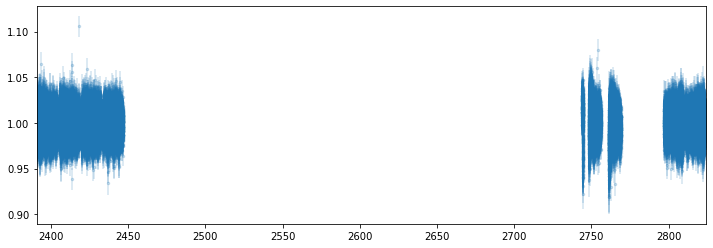

In [100]:
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Plot data:
plt.figure(figsize=(12,4))
plt.errorbar(t,f, yerr=ferr, fmt='.',alpha=0.2)
plt.xlim([np.min(t),np.max(t)])

## Detrending

In [101]:
# First, block out the transits
# Get phases --- identify out-of-transit (oot) times by phasing the data
# and selecting all points at absolute phases larger than 0.02:
phases = juliet.utils.get_phases(t, p1, tc1)
idx_oot = np.where(np.abs(phases)>0.02)[0]
# Save the out-of-transit data into dictionaries so we can feed them to juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot],f[idx_oot],ferr[idx_oot]

In [102]:
# Perform the juliet fit. Load dataset first (note the GP regressor will be the times):
dataset = juliet.load(priors='./detrending/priors.txt', t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, GP_regressors_lc = times, \
                      out_folder = './detrending/')

Exception: INPUT ERROR: GP regressors for instrument TESS use celerite, and are not in ascending or descending order. Please, give the input in those orders --- it will not work othersie.

In [ ]:
results = dataset.fit()

In [ ]:
# Get model to visually check
model_fit = results.lc.evaluate('TESS')

# Plot:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])

# First the data and the model on top:
ax1 = plt.subplot(gs[0])
ax1.errorbar(times['TESS'], fluxes['TESS'], fluxes_error['TESS'],fmt='.',alpha=0.1)
ax1.plot(times['TESS'], model_fit, color='black', zorder=100)
ax1.set_ylabel('Relative flux')
ax1.set_xlim(np.min(times['TESS']),np.max(times['TESS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Now the residuals:
ax2 = plt.subplot(gs[1])
ax2.errorbar(times['TESS'], (fluxes['TESS']-model_fit)*1e6, \
             fluxes_error['TESS']*1e6,fmt='.',alpha=0.1)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD - 2457000)')
ax2.set_xlim(np.min(times['TESS']),np.max(times['TESS']))

In [ ]:
# Get juliet model prediction for the full lightcurve:
model_prediction = results.lc.evaluate('TESS', t = t, GPregressors = t)
# this is the general trend you want to remove from the TESS light curve

# Repopulate dictionaries with new detrended flux:
# Think about how you want to detrend the light curve, and scale the errors in flux as well
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot], (f/model_prediction)[idx_oot], \
            (ferr/model_prediction)[idx_oot]

## Transit Fit

In [ ]:
dataset = juliet.load(priors='./transit_fit_4439_TESS/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = './transit_fit_4439_TESS/')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_TESS/_dynesty_NS_posteriors.pkl


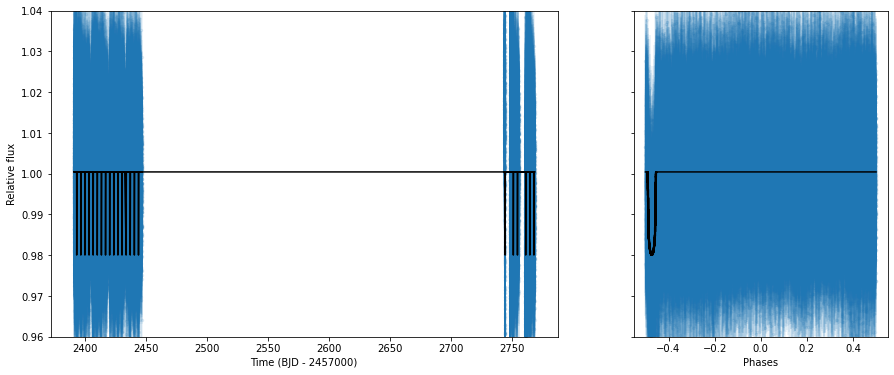

In [ ]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

# ax1.set_xlim([2403.2,2403.7])
ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')
plt.show()